* [1.Load Data From CSV File](#ld)
* [2.Build a pipeline](#bp)
* [3.Idée pour choisir le meilleur modèle](#ic)
* [4.Modèles de machine learning choisis](#mml)


In [2]:
#!pip install xgboost

In [3]:
#!pip install lightgbm 

In [49]:
#!pip install joblib

In [66]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from  xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedGroupKFold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from time import time

import joblib
import shap
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [5]:
############Fonction affichant les variables corrélés en fixant un seuil
def f_strong_correlation(threshold_up ,df2):
    #threshold_up = 0.7
    corr_pairs = df2.corr().unstack().sort_values(kind="quicksort")
    strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold_up)])
               .reset_index().rename(columns={0:'corr_coeff'}))
    strong_corr = strong_corr[(strong_corr.index%2 == 0) & 
                          (strong_corr['level_0'] != strong_corr['level_1'])]
    strong_corr.sort_values('corr_coeff', ascending=False)
    return strong_corr

### 1.Load Data From CSV File<a class="anchor" id="ld"></a>

In [6]:
#df = pd.read_csv('prepared_data.csv', sep='\t')

df = pd.read_csv('df_quantile.csv',sep='\t')



In [7]:
df

,OSEBuildingID,%NaturalGas(kBtu),%SteamUse(kBtu),BuildingType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,tranche_date,BuildingAge,groups_neighborhood,groups_PrimaryPropertyType,GFABuildingRate
0,1,-0.102156,1.780760,NonResidential,-5.199338,1.579469,0.526416,-0.698331,0.468375,0.686155,1.063067,1.032726,tranche_date1,89,Various,Various,5.199338
1,2,1.124928,-5.199338,NonResidential,-5.199338,1.513075,0.672627,-0.676067,0.404029,0.785512,1.186095,1.038121,tranche_date3,20,Various,Various,-0.891433
2,3,-0.449644,1.811514,NonResidential,-5.199338,2.391518,2.294560,-1.018128,0.872260,2.764908,2.956706,0.798036,tranche_date2,47,Various,Various,-1.024762
3,5,0.078370,1.850416,NonResidential,-5.199338,1.431438,0.257700,-0.794587,0.711613,0.648032,1.153135,1.474777,tranche_date1,90,Various,Various,5.199338
4,8,1.164911,-5.199338,NonResidential,-5.199338,1.811195,1.046169,0.551688,0.682473,1.145998,1.599488,1.042423,tranche_date3,36,Various,Various,-1.432289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,50221,0.200061,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.511288,-0.138583,-0.113266,-0.956453,-0.664672,0.179283,tranche_date3,34,Various,Various,5.199338
1537,50223,1.000820,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.654090,-0.138583,-0.261901,-0.937300,-0.346737,0.717694,tranche_date4,12,Various,Various,5.199338
1538,50224,1.415149,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.844696,-0.138583,2.205546,0.542936,0.985572,2.901564,tranche_date2,42,Various,Various,5.199338
1539,50225,0.776000,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.769757,-0.138583,-0.383428,-1.226110,-0.615832,0.505473,tranche_date3,27,Various,Various,5.199338


In [8]:
df.shape

(1541, 17)

In [9]:
columns=list(df.columns)
columns

['OSEBuildingID',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'BuildingType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'tranche_date',
 'BuildingAge',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'GFABuildingRate']

In [10]:
target1='TotalGHGEmissions'
target2='SiteEnergyUse(kBtu)'

In [11]:
f_strong_correlation(0.7 ,df)

,level_0,level_1,corr_coeff
0,PropertyGFATotal,SiteEnergyUse(kBtu),0.716380
2,SiteEnergyUse(kBtu),SourceEUI(kBtu/sf),0.732017
4,TotalGHGEmissions,GHGEmissionsIntensity,0.756458
6,SiteEnergyUse(kBtu),TotalGHGEmissions,0.885268


In [12]:
#ici on élimine 'OSEBuildingID' et ''TotalGHGEmissions''(target1)
cols=list(set(columns)-set(['OSEBuildingID','PropertyGFATotal','SourceEUI(kBtu/sf)',target1]))
cols

['BuildingType',
 'GHGEmissionsIntensity',
 '%SteamUse(kBtu)',
 'tranche_date',
 'GFABuildingRate',
 'groups_PrimaryPropertyType',
 'NumberofFloors',
 'SiteEnergyUse(kBtu)',
 'BuildingAge',
 'ENERGYSTARScore',
 '%NaturalGas(kBtu)',
 'NumberofBuildings',
 'groups_neighborhood']

In [13]:
df=df[cols]

In [14]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
print(numercial_cols)

['GHGEmissionsIntensity', '%SteamUse(kBtu)', 'GFABuildingRate', 'NumberofFloors', 'SiteEnergyUse(kBtu)', 'BuildingAge', 'ENERGYSTARScore', '%NaturalGas(kBtu)', 'NumberofBuildings']


In [15]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
print(categorical_cols)

['BuildingType', 'tranche_date', 'groups_PrimaryPropertyType', 'groups_neighborhood']


In [16]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [17]:
df['groups_neighborhood'].unique()

array(['Various', 'North', 'Central', 'South'], dtype=object)

In [18]:
df['tranche_date'].unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

In [19]:
df['groups_PrimaryPropertyType'].unique()

array(['Various', 'Commerce', 'Health'], dtype=object)

In [20]:
df.shape

(1541, 13)

In [21]:
numercial_cols_for_transformer=list(set(numercial_cols)-set([target2]))

In [22]:
numercial_cols_for_transformer

['GHGEmissionsIntensity',
 '%SteamUse(kBtu)',
 'GFABuildingRate',
 'NumberofFloors',
 'BuildingAge',
 'ENERGYSTARScore',
 'NumberofBuildings',
 '%NaturalGas(kBtu)']

## 2.Build a pipeline <a class="anchor" id="bp"></a>

In [23]:
# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore",drop='first')
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [24]:
def feature_after_transformer(preprocessor):
    tx = preprocessor.get_params()['transformers']
    feature_names = []
    for name,transformer,features in tx:
        try:
            Var = preprocessor.named_transformers_[name].get_feature_names_out().tolist()
        except AttributeError:
            Var = features
        feature_names = feature_names + Var

    return feature_names

In [25]:
feature_after_transformer(preprocessor)

['GHGEmissionsIntensity',
 '%SteamUse(kBtu)',
 'GFABuildingRate',
 'NumberofFloors',
 'BuildingAge',
 'ENERGYSTARScore',
 'NumberofBuildings',
 '%NaturalGas(kBtu)',
 'BuildingType',
 'tranche_date',
 'groups_PrimaryPropertyType',
 'groups_neighborhood']

In [26]:
y=df[[target2]]
y= StandardScaler().fit_transform(y)
features=list(set(cols)-set([target2]))
X=df[features]

#### Continuous target stratification

In [27]:
bins = np.linspace(0, len(y), 100)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y, bins)

# Pass y_binned to the stratify argument,
# and sklearn will handle the rest



In [28]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=0)

## 3.Idée pour choisir le meilleur modèle <a class="anchor" id="ic"></a>

In [29]:
regressors = [DummyRegressor(strategy="median",constant=None,quantile=0.5),
              LinearRegression(fit_intercept=True,normalize=True,copy_X=True),
              Ridge(alpha=5,solver='auto',fit_intercept=True),
              Lasso(tol=1e-3,selection='random',fit_intercept=True),
              ElasticNet(tol=1e-3,selection='random',fit_intercept=True),
              RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'),
              SVR(kernel='rbf',degree=3,gamma='scale'),
              LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1),
              XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 300)
              ]

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor),("model", model)])
    
    pip.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
   
    print("\tMean squared error:", mean_squared_error(y_test, y_pred))
    print("\tRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

DummyRegressor(quantile=0.5, strategy='median')
	Training time: 0.031s
	Prediction time: 0.016s
	Mean squared error: 1.200507790674351
	RMSE: 1.0956768641686065
	R2 score: -0.001191377759159229

LinearRegression(normalize=True)
	Training time: 3.112s
	Prediction time: 0.038s
	Mean squared error: 0.5417712699661208
	RMSE: 0.7360511327116621
	R2 score: 0.5481772559734721

Ridge(alpha=5)
	Training time: 0.528s
	Prediction time: 0.016s
	Mean squared error: 0.5438532300070404
	RMSE: 0.7374640533660203
	R2 score: 0.5464409570023201

Lasso(selection='random', tol=0.001)
	Training time: 0.078s
	Prediction time: 0.016s
	Mean squared error: 1.2013293285247153
	RMSE: 1.096051699749932
	R2 score: -0.0018765183460649482

ElasticNet(selection='random', tol=0.001)
	Training time: 0.016s
	Prediction time: 0.016s
	Mean squared error: 1.2013293285247153
	RMSE: 1.096051699749932
	R2 score: -0.0018765183460649482

RandomForestRegressor(max_leaf_nodes=1000, n_estimators=300)
	Training time: 2.684s
	Predict

**Note**
<br>
Dans la suite en se basant sur le coefficient de détermination (R2 score), on va travailler sur RandmForestRgressor et XGBRegressor.

## 4.Modèles de machine learning choisis<a class="anchor" id="mml"></a>

In [31]:
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')

In [32]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

##### 

## 4.5.RandomForestRegressor

In [35]:
clf_rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'))]
)
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['GHGEmissionsIntensity',
                                                   '%SteamUse(kBtu)',
                                                   'GFABuildingRate',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'ENERGYSTARScore',
                                                   'NumberofBuildings',
                                                   '%NaturalGas(kBtu)']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                           

### 4.5.1.Indicateurs de performance

In [36]:
f_performance(clf_rf)

******************
MSE : 0.306
RMSE : 0.553
R2 : 0.745


### 4.5.2.Optimisation du modèle

In [ ]:
list(clf_rf.get_params().keys())

In [37]:
param_grid = {
    
    #"model__max_leaf_nodes": [1000,5000,100000,None],
    "model__n_estimators": [1000,500,100],
     "model__criterion": ['squared_error', 'absolute_error', 'poisson']
    
}
grid_search = GridSearchCV(clf_rf, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['GHGEmissionsIntensity',
                                                                          '%SteamUse(kBtu)',
                                                                          'GFABuildingRate',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'ENERGYSTARScore',
                                                                          

In [38]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.999395,0.728677,0.200200,0.041435,squared_error,1000,"{'model__criterion': 'squared_error', 'model__...",0.719109,0.739813,0.627431,0.764045,0.688687,0.659126,0.607598,0.701744,0.698733,0.751333,0.695762,0.049107,2
1,4.190207,0.226883,0.089549,0.005020,squared_error,500,"{'model__criterion': 'squared_error', 'model__...",0.716602,0.739711,0.625770,0.763076,0.688901,0.660420,0.606162,0.702326,0.697111,0.755631,0.695571,0.049748,3
2,0.834027,0.042249,0.025188,0.002230,squared_error,100,"{'model__criterion': 'squared_error', 'model__...",0.705789,0.730612,0.622076,0.766261,0.675736,0.660321,0.591599,0.691611,0.699577,0.759766,0.690335,0.052967,5
3,76.440426,3.187824,0.220987,0.050388,absolute_error,1000,"{'model__criterion': 'absolute_error', 'model_...",0.730978,0.744825,0.597782,0.757606,0.696281,0.658507,0.601141,0.719603,0.698996,0.753375,0.695909,0.055957,1
4,37.634250,1.913223,0.102444,0.007856,absolute_error,500,"{'model__criterion': 'absolute_error', 'model_...",0.726037,0.744629,0.600212,0.752752,0.697374,0.651238,0.593745,0.715774,0.702656,0.749301,0.693372,0.055975,4
5,7.506194,0.196018,0.029186,0.002673,absolute_error,100,"{'model__criterion': 'absolute_error', 'model_...",0.713350,0.744365,0.583924,0.765233,0.680196,0.659209,0.578525,0.724241,0.697790,0.749552,0.689639,0.062179,6
6,0.017690,0.002573,0.000000,0.000000,poisson,1000,"{'model__criterion': 'poisson', 'model__n_esti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.018989,0.002487,0.000000,0.000000,poisson,500,"{'model__criterion': 'poisson', 'model__n_esti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
8,0.025485,0.006165,0.000000,0.000000,poisson,100,"{'model__criterion': 'poisson', 'model__n_esti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


In [39]:
grid_search.best_params_

{'model__criterion': 'absolute_error', 'model__n_estimators': 1000}

In [63]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.285
RMSE : 0.534
R2 : 0.763


In [62]:
#save the best model
filename1 = "rf_model.joblib"
joblib.dump(best_estim, filename1)
#loaad the model
loaded_rf = joblib.load(filename1)
#f_performance(loaded_model)

******************
MSE : 0.285
RMSE : 0.534
R2 : 0.763


In [65]:
# Save the grid search
joblib.dump(grid_search, 'gridearch_xg.pkl')
#load the grid search
gs=joblib.load("gridearch_xg.pkl")
gs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['GHGEmissionsIntensity',
                                                   '%SteamUse(kBtu)',
                                                   'GFABuildingRate',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'ENERGYSTARScore',
                                                   'NumberofBuildings',
                                                   '%NaturalGas(kBtu)']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                           

## 4.6.XGBRegressor

In [41]:
clf_xg = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123))]
)
clf_xg.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['GHGEmissionsIntensity',
                                                   '%SteamUse(kBtu)',
                                                   'GFABuildingRate',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'ENERGYSTARScore',
                                                   'NumberofBuildings',
                                                   '%NaturalGas(kBtu)']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                           

### 4.6.1.Indicateurs de performance

In [42]:
f_performance(clf_xg)

******************
MSE : 0.321
RMSE : 0.566
R2 : 0.733


### 4.6.2.Optimisation du modèle

In [ ]:
#list(clf_xg.get_params().keys())

In [48]:
param_grid = {
    
    "model__booster": ['squarederror','gbtree'],
    "model__n_estimators": [1500,1000],
    
    #"model__max_leaves": [10000, 1500,1000,100],
    "model__learning_rate": [0.3, 0.5,0.1,0.01,0.001]
    
}


grid_search = GridSearchCV(clf_xg, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['GHGEmissionsIntensity',
                                                                          '%SteamUse(kBtu)',
                                                                          'GFABuildingRate',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'ENERGYSTARScore',
                                                                          

In [58]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
grid_search.best_params_
cv_results.to_csv('cvresults_xg.csv')

In [70]:
best_estim_xg=grid_search.best_estimator_
f_performance(best_estim_xg)

******************
MSE : 0.285
RMSE : 0.534
R2 : 0.763


In [68]:
#save the best model
filename = "xg_model.joblib"
joblib.dump(best_estim_xg, filename)
#loaad the model
loaded_model = joblib.load(filename)
#f_performance(loaded_model)

In [60]:
# Save the grid search
joblib.dump(grid_search, 'gridearch_xg.pkl')
#load the grid search
gs=joblib.load("gridearch_xg.pkl")
#gs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['GHGEmissionsIntensity',
                                                   '%SteamUse(kBtu)',
                                                   'GFABuildingRate',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'ENERGYSTARScore',
                                                   'NumberofBuildings',
                                                   '%NaturalGas(kBtu)']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                           

In [79]:
# fit the preprocessor 
X_encoded = grid_search.best_estimator_['preprocessor'].fit_transform(X_train)

# fit the model 
best_model = grid_search.best_estimator_['model'].fit(X_encoded, y_train)

# calculate the Shap values
shap_values = shap.TreeExplainer(best_model).shap_values(X_encoded)

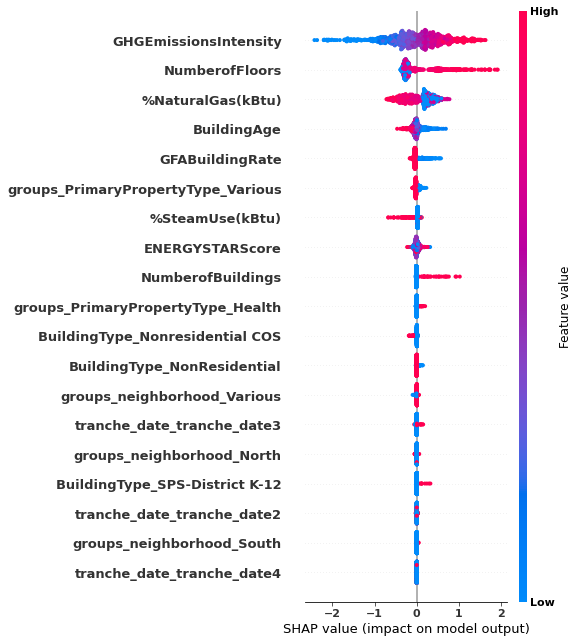

In [93]:
shap.summary_plot(shap_values, X_encoded,feature_names=feature_after_transformer(preprocessor))

**Observations**
<br>
Ce  graphique globale  montre les valeurs de Shap sur l'axe des x. Ici, toutes les valeurs à gauche représentent les observations qui déplacent la valeur prédite dans la direction négative, tandis que les points à droite contribuent à déplacer la prédiction dans une direction positive. 
<br>
L'axe y contient les variables

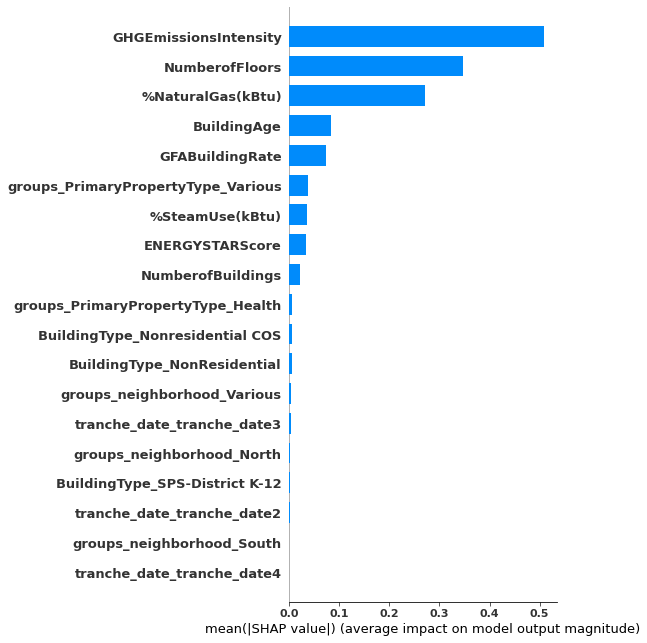

In [95]:
# plot the Shap values
shap.summary_plot(shap_values, X_encoded, plot_type='bar',feature_names=feature_after_transformer(preprocessor))

In [102]:
#shap.dependence_plot("GHGEmissionsIntensity",shap_values,X_encoded)